## 01 Import modules

In [56]:
import pandas as pd
import json
import os
import matplotlib
import matplotlib.pyplot as plt 

#### [Opt] Vars

In [9]:
#pd.set_option('display.max_columns', 50)
PATH = '../../badCorpus'
data_list = []

#### [Opt] Funcs

In [10]:
def set_dtypes(df):
    df['id'] = df['id'].astype('Int32')
    df['mbti_profile'] = df['mbti_profile'].astype('string')
    df['contributor_create_date'] = df['contributor_create_date'].astype('string')
    df['is_active'] = df['is_active'].astype('bool')
    df['is_approved'] = df['is_approved'].astype('bool')
    df['mbti_type'] = df['mbti_type'].astype('category')
    df['pdb_public_access'] = df['pdb_public_access'].astype('bool')
    df['watch_count'] = df['watch_count'].astype('Int32')
    df['comment_count'] = df['comment_count'].astype('Int32')
    df['vote_count_mbti'] = df['vote_count_mbti'].astype('Int32')
    df['total_vote_counts'] = df['total_vote_counts'].astype('Int32')
    df['cat_id'] = df['cat_id'].astype('Int8')
    df['category'] = df['category'].astype('category')
    df['sub_cat_id'] = df['sub_cat_id'].astype('Int32')
    df['subcategory'] = df['subcategory'].astype('category')
    df['functions'] = df['functions'].astype('string')
    return df

#### [Opt] Read data from JSONs

In [11]:
for file in os.listdir(PATH):
        if file.endswith(".json"):
                with open(rf'{PATH}/{file}') as f:
                        data = json.load(f)
                data_list.append(data)

#### [Opt] Create Dataframe

In [12]:
dataframe = pd.DataFrame(data_list)
dataframe['mbti_type']= dataframe.mbti_type.str.split(' ').str[0]
dataframe = set_dtypes(dataframe)

#### [Opt] Store Dataframe with Feather
- Write: 0.783s
- Read: 0.583s
- Size: 13MB

In [13]:
dataframe.to_feather('dataframe.feather')

## 02 Load Data from Feather file

In [2]:
dataframe=pd.read_feather('dataframe.feather')

## 03 Clear Data

### 03.1 Remove entries with small amount of votes
Threshhold "5":\
Reduces rows by 54 717

In [3]:
THRESHHOLD = 5
transformed_df = dataframe.query(f"total_vote_counts >= {THRESHHOLD}").copy()

### 03.2 Remove entries where mbti_type is uncertain (i.e. contains char 'x')

Reduces rows by 2366

In [4]:
rows_with_x = transformed_df[transformed_df.mbti_type.str.contains('X',case=False)].copy()
transformed_df = pd.concat([transformed_df, rows_with_x])
transformed_df = transformed_df.drop_duplicates('id', keep=False).copy()

## 04 Analysis

### 4.1 Overall Data
44 738 datapoints

In [17]:
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44738 entries, 0 to 101815
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       44738 non-null  Int32   
 1   mbti_profile             44738 non-null  string  
 2   contributor_create_date  44738 non-null  string  
 3   is_active                44738 non-null  bool    
 4   is_approved              44738 non-null  bool    
 5   mbti_type                44738 non-null  category
 6   pdb_public_access        44738 non-null  bool    
 7   watch_count              44738 non-null  Int32   
 8   comment_count            44738 non-null  Int32   
 9   vote_count_mbti          44738 non-null  Int32   
 10  total_vote_counts        44738 non-null  Int32   
 11  cat_id                   44738 non-null  Int8    
 12  category                 44738 non-null  category
 13  sub_cat_id               44738 non-null  Int32   
 14  subca

### 4.2 Data per Category
- Television   : 6485
- Cartoons     : 6355
- Anime & Manga: 5901
- Movies       : 5663
- Gaming       : 5505
- Web Comics   : 4949
- Literature   : 4306
- Superheroes  : 3036
- Theatre      : 1368
- Comics       : 1170

In [114]:
transformed_df.groupby('category', observed=True)['id'].count()

category
Television       6485
Anime & Manga    5901
Gaming           5505
Literature       4306
Web Comics       4949
Movies           5663
Comics           1170
Cartoons         6355
Superheroes      3036
Theatre          1368
Name: id, dtype: int64

### 4.3 Highest occurences of mbti_types in corpus

<Axes: xlabel='mbti_type'>

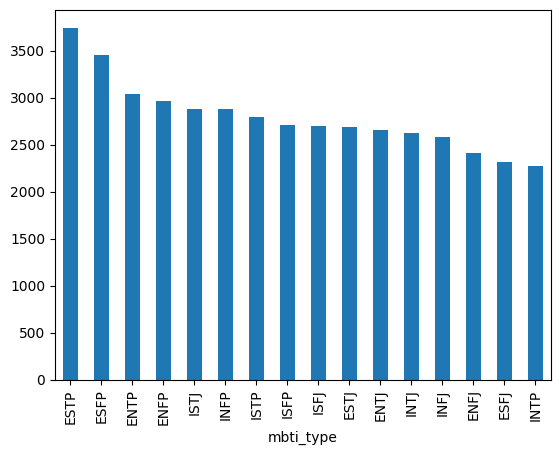

In [23]:
transformed_df.groupby('mbti_type', observed=True)['id']\
    .count()\
    .sort_values(ascending=False)\
    .plot.bar()

### 4.4 Highest occurences of mbti_types by category

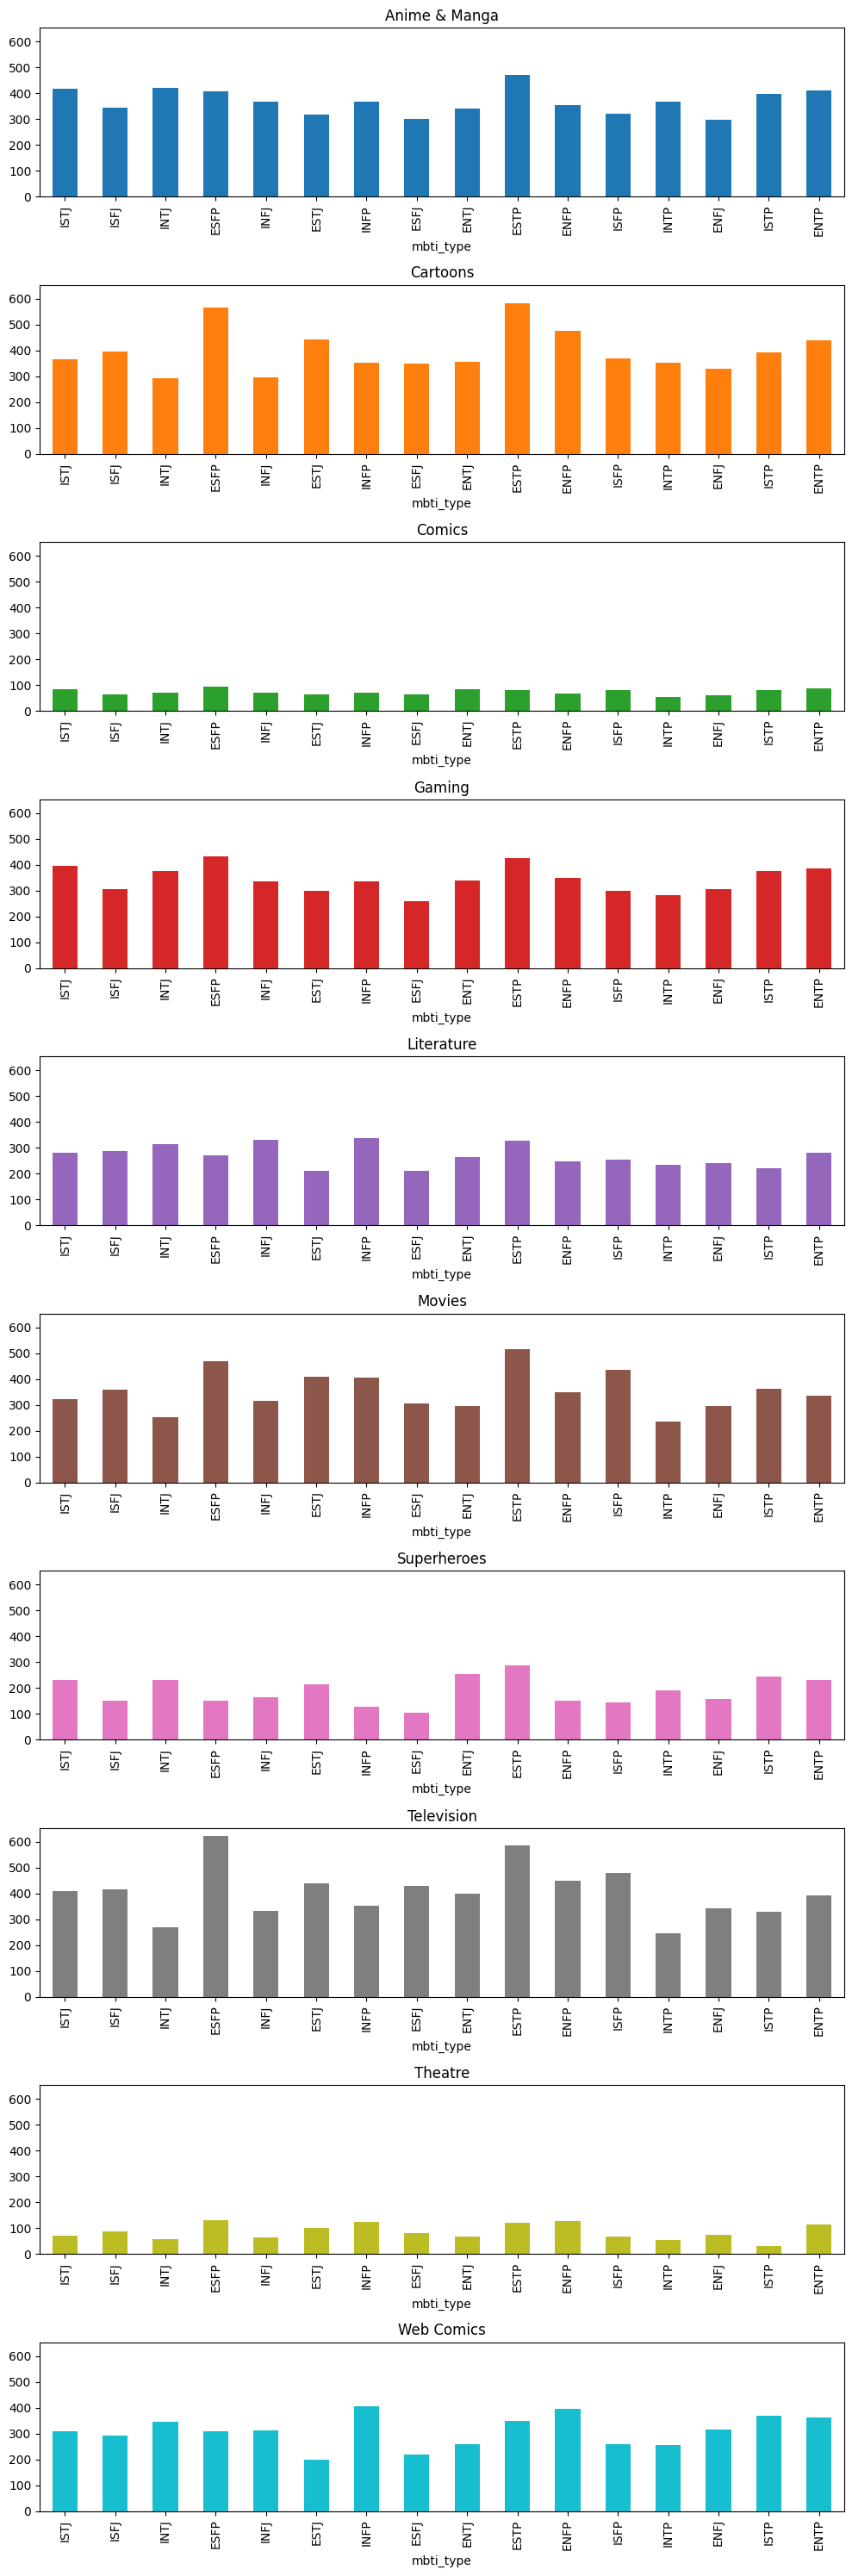

In [107]:
pivot = transformed_df.pivot_table(\
    index=['mbti_type'],\
    columns=['category'],\
    values='id',\
    aggfunc={'id': 'count'},\
    observed=True)

pivot.plot(\
    subplots=True,\
    sharey=True,\
    #grid=True,\
    layout=(10,1),\
    figsize=(10,30),\
    kind='bar',\
    sharex=False,\
    legend=False)

plt.tight_layout()